In [1]:
import time
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/HOME1/users/personal/sebne/SparseRecovery')
import algorithms.OMP as OMP

dtype = torch.float
device_id = 'cuda'

In [2]:
def generate_data(
    N, M, D, dtype=torch.float, device="cuda"
):
    # sample D-dimensional array of random points in [0,1]^D
    samples = torch.rand(
        N, D, dtype=dtype, device=device, requires_grad=False
    )

    # define D-dimensional array of frequencies in [-M, M]^D based on hyperbolic cross density
    def hyp_cross(d, M):
        if d == 1:
            return [[k] for k in range(-M, M + 1)]
        out = []
        for k in range(-M, M + 1):
            for temp in hyp_cross(d - 1, int(M / max(1, abs(k)))):
                out.append([k] + temp)
        return out

    # frequencies in [-M, M]^D scaled by -2π
    frequencies = -2 * math.pi * torch.round(
        torch.FloatTensor(hyp_cross(D, M)).to(
            dtype=torch.double, device=device_id
        )
    )
    frequencies.requires_grad = False
    M_f = frequencies.size(0)

    # function in H^3/2 with known Fourier coefficients
    def fun1(x, D):
        out = torch.ones_like(x[:, 0], requires_grad=False)
        for i in range(D):
            out = out * torch.clip(
                0.2 - (x[:, i] - 0.5) ** 2,
                min=0,
                max=None,
            )
        return (15 / (4 * np.sqrt(3)) * 5 ** (3 / 4)) ** D * out[:, None]

    def fun1_fourier_coeffs(f, D):
        out = torch.ones_like(f[:, 0], requires_grad=False)
        for i in range(D):
            tmp = (
                5 ** (5 / 4)
                * np.sqrt(3)
                * (-1) ** torch.round(f[:, i] / (2 * np.pi))
                * (
                    np.sqrt(5) * torch.sin(f[:, i] / np.sqrt(5))
                    - f[:, i] * torch.cos(f[:, i] / np.sqrt(5))
                )
                / (f[:, i] ** 3)
            )
            tmp[torch.isnan(tmp)] = 5 ** (1 / 4) / np.sqrt(3)
            out = out * tmp
        return out

    # compute truncation error
    coeffs_gt_d = torch.zeros((M_f, 2), dtype=torch.double)
    coeffs_gt_d[:, 0] = fun1_fourier_coeffs(
        frequencies.to(dtype=torch.double), D
    )
    trunc_error = torch.sqrt(1 - torch.sum(coeffs_gt_d[:, 0] ** 2))

    # cast to chosen dtype/device
    frequencies = frequencies.to(dtype=dtype)
    coeffs_gt = torch.zeros((M_f, 2), dtype=dtype, device=device_id)
    coeffs_gt[:, 0] = fun1_fourier_coeffs(frequencies, D)

    # since we approximate real functions, we can drop half of the Fourier coeffcients
    frequencies_half = frequencies[:math.ceil(frequencies.size(0)/2),:]

    # create vector with normalized function values
    values = fun1(samples,D)

    # Optionally print info
    print("Number of Fourier frequencies in Hyperbolic cross:", M_f)
    print("Truncation error computed with double precision:", trunc_error.item())

    return frequencies, frequencies_half, samples, values, coeffs_gt, trunc_error

Number of Fourier frequencies in Hyperbolic cross: 12033
Truncation error computed with double precision: 0.02121285162110815
Iteration: 1  Residual: 0.9155694246292114
Iteration: 101  Residual: 0.1984168440103531
Iteration: 201  Residual: 0.12270274013280869
Iteration: 301  Residual: 0.08822108805179596
Iteration: 401  Residual: 0.06887500733137131
Iteration: 501  Residual: 0.05833500623703003
Iteration: 601  Residual: 0.050132472068071365
Iteration: 701  Residual: 0.04390091821551323
Iteration: 801  Residual: 0.039291854947805405
Iteration: 901  Residual: 0.035894084721803665
Iteration: 1001  Residual: 0.033074311912059784
Iteration: 1101  Residual: 0.03074362687766552
Iteration: 1201  Residual: 0.0287905503064394
Iteration: 1301  Residual: 0.027145029976963997
Iteration: 1401  Residual: 0.0257007647305727
Iteration: 1501  Residual: 0.02443576231598854
Iteration: 1601  Residual: 0.023302532732486725
Iteration: 1701  Residual: 0.022284571081399918
Iteration: 1801  Residual: 0.02135206

Text(0.5, 1.0, 'Difference to Ground Truth Fourier Coefficients')

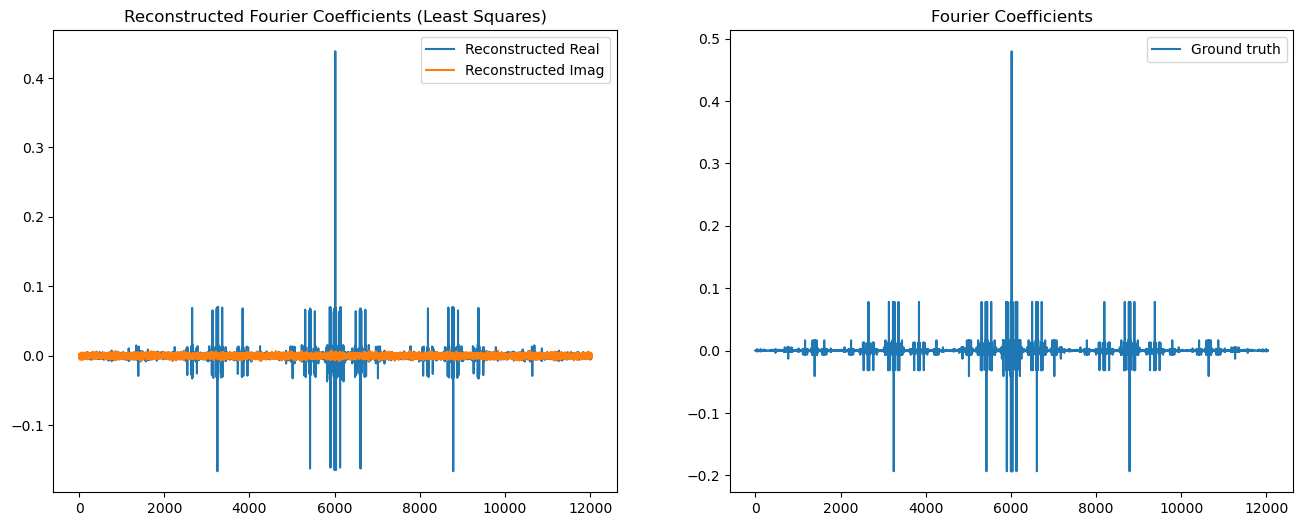

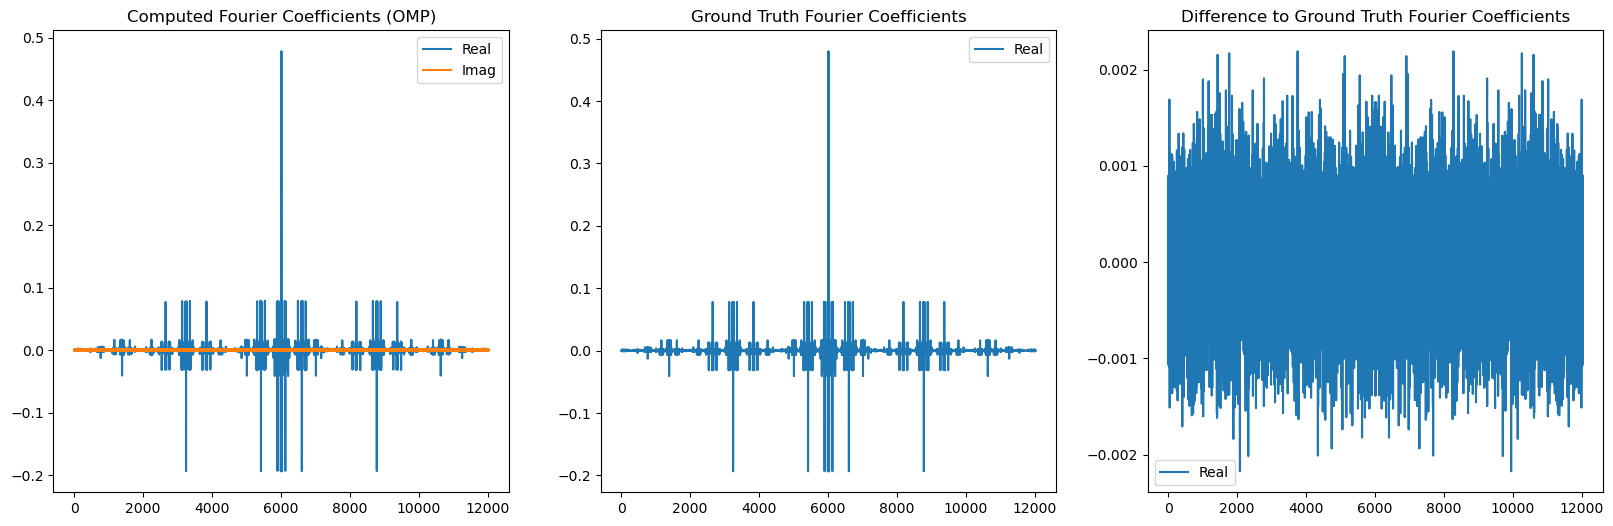

In [3]:
# include weight of L2 norm into Fourier matrix and build wrapper
frequencies, frequencies_half, samples, values, coeffs_gt, trunc_error = (
    generate_data(10000, 8, 5, device=device_id, dtype=dtype)
)

# run OMP algorithm
start = time.time()
coeffs_rec, coeffs_lsr_rec, residuals= OMP.Fourier(
    samples,
    values,
    frequencies_half,
    num_iters = 20000,
    lstsq_rec=True,
)
# add missing Fourier coeffcients
coeffs_rec = torch.cat(
    (
        coeffs_rec[:-1, :] / 2,
        coeffs_rec[-1, :][None],
        torch.flipud(coeffs_rec[:-1, :]) / 2,
    ),
    0,
)
coeffs_rec[-math.ceil(frequencies.size(0) / 2) :, 1] = -coeffs_rec[
    -math.ceil(frequencies.size(0) / 2) :, 1
]

coeffs_lsr_rec = torch.cat(
    (
        coeffs_lsr_rec[:-1, :] / 2,
        coeffs_lsr_rec[-1, :][None],
        torch.flipud(coeffs_lsr_rec[:-1, :]) / 2,
    ),
    0,
)
coeffs_lsr_rec[-math.ceil(frequencies.size(0) / 2) :, 1] = -coeffs_lsr_rec[
    -math.ceil(frequencies.size(0) / 2) :, 1
]

print("Time to compute OMP solution is", time.time() - start, "seconds")

# some evaluation metrics
print("Final residual in OMP algorithm is",residuals[0].item())
print(
    "Reconstruction error of OMP solution:",
    (trunc_error + torch.linalg.norm(coeffs_gt[:, 0] - coeffs_rec[:, 0])).item(),
)
print(
    "Number of nonzero entries of OMP solution (with tolerance 1e-4):",
    torch.sum(torch.abs(coeffs_rec) > 1e-4).item(),
)

# evaluation of some metrics
print("Residual of least squares solution is",
      residuals[1].item()
     )
print("Reconstruction error of least squares solution is",
      (trunc_error + torch.linalg.norm(coeffs_gt[:,0] - coeffs_lsr_rec[:,0])).item()
     )

fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(coeffs_lsr_rec[:, 0].cpu(), label="Reconstructed Real")
plt.plot(coeffs_lsr_rec[:, 1].cpu(), label="Reconstructed Imag")
plt.legend()
plt.title("Reconstructed Fourier Coefficients (Least Squares)")

plt.subplot(1, 2, 2)
plt.plot(coeffs_gt[:,0].cpu(), label="Ground truth")
plt.legend()
plt.title("Fourier Coefficients")

fig = plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.plot(coeffs_rec[:, 0].cpu(), label="Real")
plt.plot(coeffs_rec[:, 1].cpu(), label="Imag")
plt.legend()
plt.title("Computed Fourier Coefficients (OMP)")

plt.subplot(1, 3, 2)
plt.plot(coeffs_gt[:,0].cpu(), label="Real")
plt.legend()
plt.title("Ground Truth Fourier Coefficients")

plt.subplot(1, 3, 3)
plt.plot(coeffs_rec[:, 0].cpu() - coeffs_gt[:,0].cpu(), label="Real")
plt.legend()
plt.title("Difference to Ground Truth Fourier Coefficients")

Text(0.5, 1.0, 'Difference to Ground Truth Fourier Coefficients')

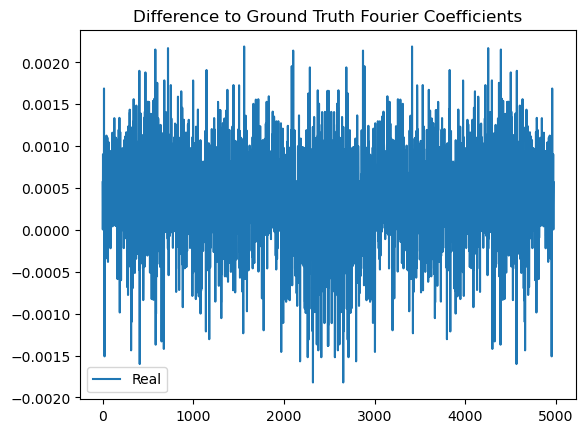

In [4]:
tmp = coeffs_rec[:, 0] - coeffs_gt[:,0]
ind = (coeffs_rec[:, 0])>0
tmp = tmp[ind]
plt.plot(tmp.cpu(), label="Real")
plt.legend()
plt.title("Difference to Ground Truth Fourier Coefficients")